In [170]:
import os
import pandas as pd

data_directory = '/content/Data'

dataframes = []

ACTIVITY_MAP = {
    'A' : 'DownStairs',
    'B' : 'Running',
    'C' : 'Sitting',
    'D' : 'Staying',
    'E' : 'Upstairs'
}

for filename in os.listdir(data_directory):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_directory, filename))
        df = df.drop(columns=['gravityX', 'gravityY', 'gravityZ', 'quaternionW', 'quaternionX', 'quaternionY', 'quaternionZ'])
        print(df)
        df['activity'] = os.path.splitext(filename)[0]
        dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

output_path = 'combined_activity_data.csv'
combined_df.to_csv(output_path, index=False)

print(f'Объединенный файл сохранен по пути: {output_path}')

                      time  seconds_elapsed  rotationRateX  rotationRateY  \
0      1718556934208165600         0.120166      -0.617923      -0.444125   
1      1718556934218113500         0.130114      -0.710847      -0.396706   
2      1718556934228063000         0.140063      -0.768954      -0.338885   
3      1718556934238010600         0.150011      -0.760009      -0.303767   
4      1718556934247959800         0.159960      -0.766248      -0.278948   
...                    ...              ...            ...            ...   
14632  1718557079777983700       145.689984      -0.213059       0.030444   
14633  1718557079787933000       145.699933      -0.190713      -0.059019   
14634  1718557079797880600       145.709881      -0.090189      -0.047295   
14635  1718557079807829800       145.719830      -0.052953      -0.048930   
14636  1718557079817779000       145.729779      -0.058721      -0.059493   

       rotationRateZ  accelerationX  accelerationY  accelerationZ  
0      

In [171]:
import os
import datetime
import glob
import requests
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

%matplotlib inline

In [172]:
har_df = combined_df
display(har_df.head())
display(har_df.shape)

,time,seconds_elapsed,rotationRateX,rotationRateY,rotationRateZ,accelerationX,accelerationY,accelerationZ,activity
0,1718556934208165600,0.120166,-0.617923,-0.444125,-0.222103,-0.030652,-0.085566,0.041613,Running
1,1718556934218113500,0.130114,-0.710847,-0.396706,-0.220649,-0.040305,-0.087173,0.060821,Running
2,1718556934228063000,0.140063,-0.768954,-0.338885,-0.178581,-0.040646,-0.073354,0.082964,Running
3,1718556934238010600,0.150011,-0.760009,-0.303767,-0.136627,-0.035585,-0.079050,0.113999,Running
4,1718556934247959800,0.159960,-0.766248,-0.278948,-0.109886,-0.023255,-0.089210,0.135739,Running


(102969, 9)

In [173]:
print(har_df)

                       time  seconds_elapsed  rotationRateX  rotationRateY  \
0       1718556934208165600         0.120166      -0.617923      -0.444125   
1       1718556934218113500         0.130114      -0.710847      -0.396706   
2       1718556934228063000         0.140063      -0.768954      -0.338885   
3       1718556934238010600         0.150011      -0.760009      -0.303767   
4       1718556934247959800         0.159960      -0.766248      -0.278948   
...                     ...              ...            ...            ...   
102964  1718556052781001200       302.489001       0.001103       0.009775   
102965  1718556052790950400       302.498950      -0.016303       0.024933   
102966  1718556052800900000       302.508900       0.000139       0.022561   
102967  1718556052810849300       302.518849       0.018705      -0.007833   
102968  1718556052820799200       302.528799       0.027297      -0.024360   

        rotationRateZ  accelerationX  accelerationY  accelerati

In [174]:
har_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102969 entries, 0 to 102968
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   time             102969 non-null  int64  
 1   seconds_elapsed  102969 non-null  float64
 2   rotationRateX    102969 non-null  float64
 3   rotationRateY    102969 non-null  float64
 4   rotationRateZ    102969 non-null  float64
 5   accelerationX    102969 non-null  float64
 6   accelerationY    102969 non-null  float64
 7   accelerationZ    102969 non-null  float64
 8   activity         102969 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 7.1+ MB


In [175]:
FEATURES = ['rotationRateX', 'rotationRateY', 'rotationRateZ', 'accelerationX', 'accelerationY', 'accelerationZ']

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

stats_df = har_df[FEATURES].describe().loc[['count','mean','std','min','max']].round(3)
stats_df.style.applymap(color_negative_red)

,rotationRateX,rotationRateY,rotationRateZ,accelerationX,accelerationY,accelerationZ
count,102969.000000,102969.000000,102969.000000,102969.000000,102969.000000,102969.000000
mean,-0.003000,0.013000,-0.002000,0.057000,0.018000,0.018000
std,0.687000,0.451000,1.278000,0.186000,0.242000,0.125000
min,-5.577000,-3.020000,-5.204000,-0.729000,-1.008000,-0.613000
max,8.759000,2.722000,5.749000,1.393000,1.223000,0.982000


Text(0, 0.5, 'Count')

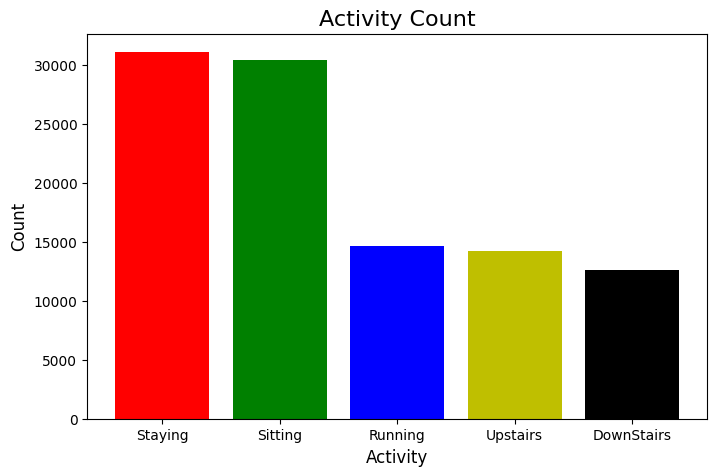

In [176]:
activity_count = har_df.activity.value_counts()

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(activity_count.index, activity_count.values, color=['r', 'g', 'b', 'y', 'k'])
ax.set_title('Activity Count', {'fontsize': 16})
ax.set_xlabel('Activity', {'fontsize': 12})
ax.set_ylabel('Count', {'fontsize': 12})

In [177]:
SEQ_LEN = 200
COLUMNS = ['rotationRateX', 'rotationRateY', 'rotationRateZ', 'accelerationX', 'accelerationY', 'accelerationZ']
DIMS = len(COLUMNS)



In [178]:
scaler = MinMaxScaler()
har_df[COLUMNS] = scaler.fit_transform(har_df[COLUMNS])

encoder = LabelEncoder()
har_df['activity'] = encoder.fit_transform(har_df['activity'])

In [179]:
X = []
y = []

for index, data in har_df.groupby([ 'activity'], sort=False):
    data = data[COLUMNS].values
    label = index
    for i in range(0, len(data) - SEQ_LEN, SEQ_LEN):
        X.append(np.expand_dims(data[i:i+SEQ_LEN], axis=0))
        y.append(label)

X = np.concatenate(X)
y = np.asarray(y)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=43)

In [181]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, input_shape=(SEQ_LEN, DIMS)),
    tf.keras.layers.LSTM(units=32),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 58, 32)            608       
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 5)                 325       
                                                                 
Total params: 11365 (44.39 KB)
Trainable params: 11365 (44.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [182]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.2)

Epoch 1/100
35/35 [==============================] - 4s 49ms/step - loss: 1.5508 - accuracy: 0.2746 - val_loss: 1.5555 - val_accuracy: 0.2701
Epoch 2/100
35/35 [==============================] - 1s 34ms/step - loss: 1.5021 - accuracy: 0.2974 - val_loss: 1.4601 - val_accuracy: 0.3066
Epoch 3/100
35/35 [==============================] - 1s 32ms/step - loss: 1.3680 - accuracy: 0.3823 - val_loss: 1.2298 - val_accuracy: 0.3832
Epoch 4/100
35/35 [==============================] - 1s 31ms/step - loss: 1.2035 - accuracy: 0.4252 - val_loss: 1.0799 - val_accuracy: 0.4124
Epoch 5/100
35/35 [==============================] - 1s 30ms/step - loss: 1.1490 - accuracy: 0.4024 - val_loss: 1.0113 - val_accuracy: 0.4416
Epoch 6/100
35/35 [==============================] - 1s 31ms/step - loss: 1.0499 - accuracy: 0.4334 - val_loss: 0.9257 - val_accuracy: 0.4307
Epoch 7/100
35/35 [==============================] - 1s 43ms/step - loss: 1.2258 - accuracy: 0.3887 - val_loss: 0.9368 - val_accuracy: 0.5219
Epoch 

In [183]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 10ms/step - loss: 0.3626 - accuracy: 0.8950


[0.362576425075531, 0.8950437307357788]

In [184]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

11/11 [==============================] - 1s 9ms/step


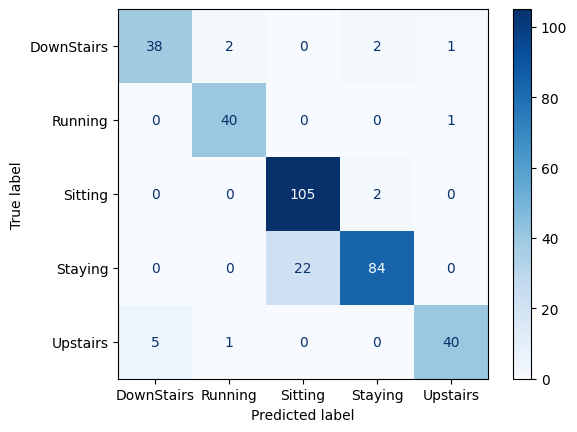

In [185]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_labels = ['DownStairs', 'Running', 'Sitting', 'Staying', 'Upstairs']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [186]:
!pip install coremltools

In [187]:
import coremltools as ct

coreml_model = ct.convert(model, inputs=[ct.TensorType(shape=(1, X_train.shape[1], X_train.shape[2]))], minimum_deployment_target=ct.target.iOS14)

coreml_model.save('CoreMLModel.mlpackage')

Converting TF Frontend ==> MIL Ops:   0%|          | 0/59 [00:00<?, ? ops/s]WARNING:coremltools:Saving value type of int64 into a builtin type of int32, might lose precision!

Converting TF Frontend ==> MIL Ops: 100%|██████████| 14/14 [00:00<00:00, 18202.19 ops/s]

Converting TF Frontend ==> MIL Ops: 100%|██████████| 41/41 [00:00<00:00, 2795.79 ops/s]

Converting TF Frontend ==> MIL Ops: 100%|██████████| 14/14 [00:00<00:00, 17897.06 ops/s]

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 1/1 [00:00<00:00, 2392.64 ops/s]

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 56/56 [00:00<00:00, 1416.44 ops/s]


In [188]:
!zip -r /content/file.zip /content/CoreMLModel.mlpackage

updating: content/CoreMLModel.mlpackage/ (stored 0%)
updating: content/CoreMLModel.mlpackage/Data/ (stored 0%)
updating: content/CoreMLModel.mlpackage/Data/com.apple.CoreML/ (stored 0%)
updating: content/CoreMLModel.mlpackage/Data/com.apple.CoreML/model.mlmodel (deflated 32%)
updating: content/CoreMLModel.mlpackage/Manifest.json (deflated 48%)


In [189]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>